# Report: Ex2 - Locating objects in images

## Tore Aadland

Optional tasks done:
 * B - Segmentation. I use a Mask R-CNN implementation available at: https://github.com/matterport/Mask_RCNN, and I start using the following example as a template: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb .

First lets load the required libraries:

In [1]:
# FROM: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Only minor changes done by me.

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import os.path as path

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Config class
To use the Mask R-CNN implementation available at https://github.com/matterport/Mask_RCNN, one must provide a Config class. I make a custom class following the directions of cell 2 in https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb.

In [2]:
class FishConfig(Config):
    NAME = "fish"
    NUM_CLASSES = 3
    STEPS_PER_EPOCH = 1000
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    VALIDATION_STEPS = 5
    
config = FishConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Dataset class
To use the Mask R-CNN implementation available at https://github.com/matterport/Mask_RCNN, one must provide a Dataset class. I make a custom class following the directions of cell 4 in https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb.

The class must overide load_image, load_mask and image_reference methods.

In [7]:
# FROM: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Major changes done by me.

class FishDataset(utils.Dataset):
    def load_fish(self, path_to_contents):
        self.fish2int = {
            "Mackerel": 1,
            "Herring": 2,
        }
        
        self.int2fish = {}
        for key, val in self.fish2int.items():
            self.int2fish[val] = key
        
        for fish, i in self.fish2int.items():
            self.add_class("fish", i, fish)

        data = {}
        contents = pd.read_csv(path_to_contents, delimiter=',')
        id = 0
        for name, rgbpath, maskpath in zip(contents['log_file'], contents['rgb_path'], contents['mask_path']):
            masks = []
            data = pd.read_csv(maskpath, delimiter='\t', header=None)
            for key, val in data.values[:,(0,-1)]:
                masks.append((self.fish2int[key]-1,val))
            self.add_image("fish", image_id=id, path=rgbpath, width=256, height=256, masks=masks)
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        image = io.imread(info['path'])
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        masks = info["masks"]
        count = len(masks)
        mask = np.zeros((256,256,count), dtype=np.uint8)
        klasser = []
        for i, (klasse, path) in enumerate(masks):
            klasser.append(klasse+1)
            img = io.imread(path)
            mask[:,:,i] = img[:,:]
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        return mask.astype(np.bool), np.array(klasser, dtype=np.int32)
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "fish":
            return info["fish"]
        else:
            super(self.__class__).image_reference(self, image_id)

## Data
To train my machine learning model I use computer generated renderings of a herring and a mackerel model available at https://sketchfab.com/3d-models/herring-00d9af1156df4440acd5d98912f9a6e2 and https://sketchfab.com/3d-models/mackerel-4e73d0ba00744cd7af781ff44637b0a7. I render the images in blender and vary the scale, rotation, amount of deformation of the fish, and light intensity in the images. This way I make 447 cut out images of the herring and of the mackerel. These images are used to generate my training data. 

Here are som examples of the computer generated mackerel images used to in the composite images of the training data:

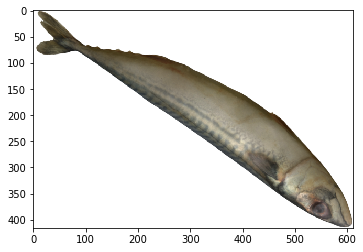

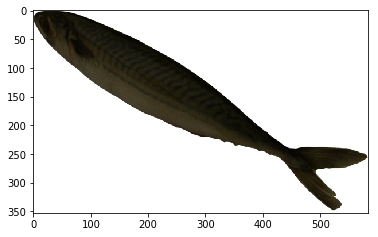

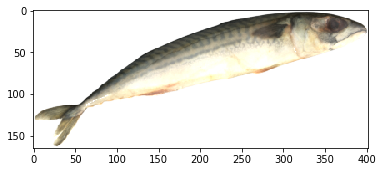

In [29]:
blender_mackerel = [ r"./source_data/HerringMackerel/Blender/Mackerel/0200.png", r"./source_data/HerringMackerel/Blender/Mackerel/dark_0010.png", r"./source_data/HerringMackerel/Blender/Mackerel/light_0065.png"]

for fp in blender_mackerel:
    im = io.imread(fp)
    plt.imshow(im)
    plt.show()

Here are som examples of the computer generated herring images used to in the composite images of the training data:

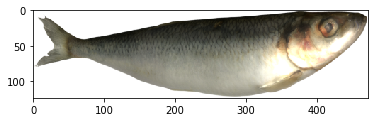

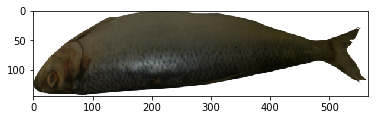

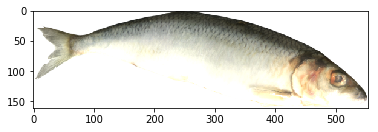

In [33]:
blender_herring = [ r"./source_data/HerringMackerel/Blender/Herring/0000.png", r"./source_data/HerringMackerel/Blender/Herring/dark_0010.png", r"./source_data/HerringMackerel/Blender/Herring/light_0049.png"]

for fp in blender_herring:
    im = io.imread(fp)
    plt.imshow(im)
    plt.show()

I use the cutout images of herring and mackerel provided in the assignment to generate my validation and testing data.

To generate my syntethic fish composite images I use modify the code provided in https://github.com/ketil-malde/image-simulator to also save the image mask. My fork of the repo with my modifications is available at: https://github.com/ToreAad/image-simulator.

So... Having rendered the images in blender, and having generated my training, validation and test composite images I now need to load my data:

## Visualising my dataset
Cell 6 of https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb provides code to visualize the data represented by the overloaded dataset class. Lets use it to see if everything is sane and as expected. Lets start with the training data:

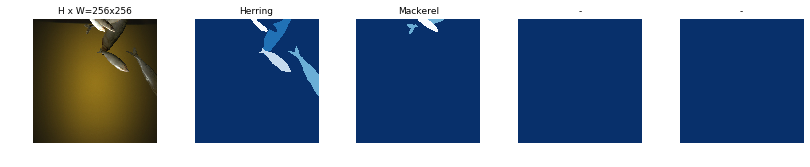

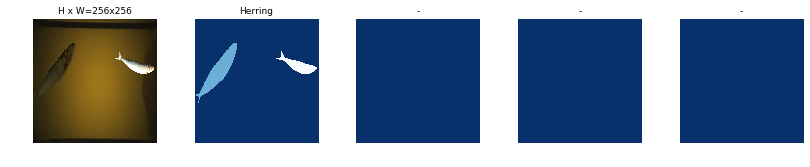

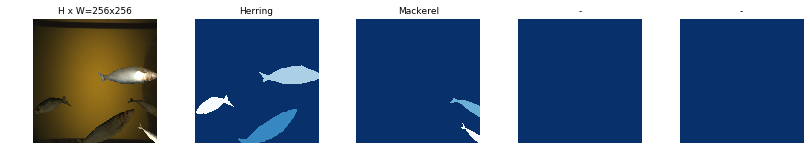

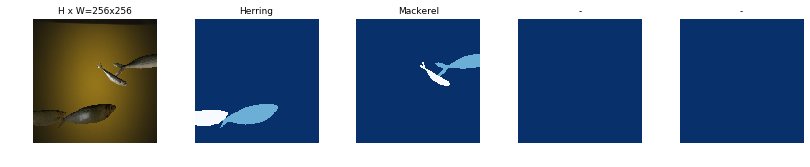

In [9]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# No modifications done by me.

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

Then the testing data:

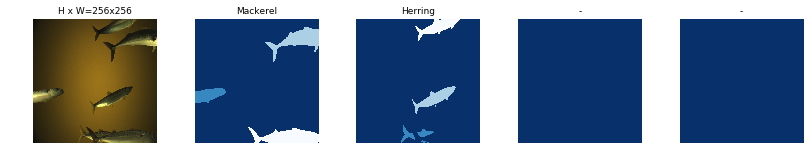

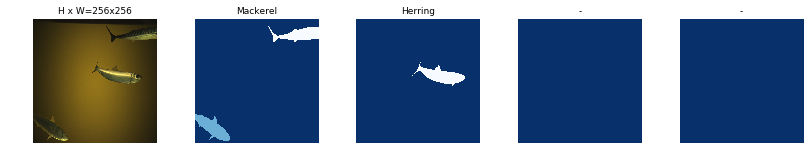

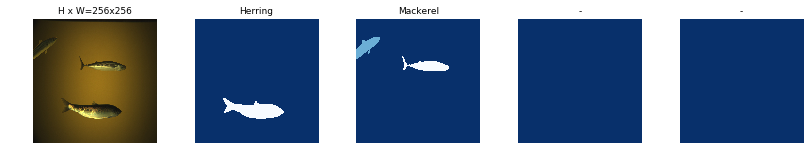

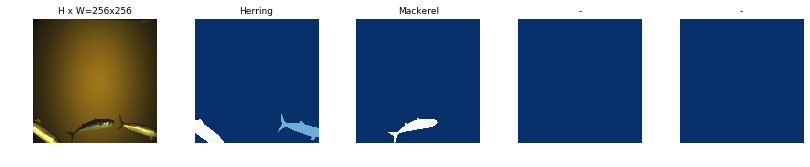

In [10]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# No modifications done by me.

# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

Everything seems ok.

## Loading Mask R-CNN model

To load the mask r-cnn model I follow the exmample of cell 7 in https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb. 

In [27]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# No modifications done by me.

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 10


## Training the model
To train the model I follow the examples of cell 8-10 in https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb.

In [13]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# I only changed the number of epochs trained.


# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jupyter/image-simulator/logs/fish20190424T0855/mask_rcnn_fish_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_

/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 356s 356ms/step - loss: 1.1517 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.6353 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.1564 - val_loss: 1.1951 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.6075 - val_mrcnn_class_loss: 0.2451 - val_mrcnn_bbox_loss: 0.2021 - val_mrcnn_mask_loss: 0.1298
Epoch 2/10
1000/1000 [==============================] - 329s 329ms/step - loss: 0.7827 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4076 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.1204 - val_loss: 1.6369 - val_rpn_class_loss: 0.0157 - val_rpn_bbox_loss: 1.0540 - val_mrcnn_class_loss: 0.2179 - val_mrcnn_bbox_loss: 0.1876 - val_mrcnn_mask_loss: 0.1618
Epoch 3/10
1000/1000 [==============================] - 288s 288ms/step - loss: 0.6508 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.3235 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.1124 - val_loss: 1.3162 - val_rpn_cla

In [28]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# I only changed the number of epochs trained.

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=15, 
            layers="all")


Starting at epoch 10. LR=0.0001

Checkpoint Path: /home/jupyter/image-simulator/logs/fish20190424T0855/mask_rcnn_fish_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 11/15
1000/1000 [==============================] - 423s 423ms/step - loss: 0.3588 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.0868 - val_loss: 1.4318 - val_rpn_class_loss: 0.0274 - val_rpn_bbox_loss: 0.9313 - val_mrcnn_class_loss: 0.1532 - val_mrcnn_bbox_loss: 0.1477 - val_mrcnn_mask_loss: 0.1722
Epoch 12/15
1000/1000 [==============================] - 384s 384ms/step - loss: 0.3446 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1510 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.0867 - val_loss: 1.2901 - val_rpn_class_loss: 0.0131 - val_rpn_bbox_loss: 0.6084 - val_mrcnn_class_loss: 0.2780 - val_mrcnn_bbox_loss: 0.1872 - val_mrcnn_mask_loss: 0.2034
Epoch 13/15
1000/1000 [==============================] - 383s 383ms/step - loss: 0.3121 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1286 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.0825 - val_loss: 0.5825

In [14]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# I only changed the number of epochs trained.

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=35, 
            layers='heads')


Starting at epoch 30. LR=0.001

Checkpoint Path: /home/jupyter/image-simulator/logs/fish20190416T2000/mask_rcnn_fish_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn

In [15]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Basically no modification by me.

# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_blender_17042019.h5")
#model.keras_model.save_weights(model_path)

## Image segmentation
To test the trained model I use the code from cell 11 to 13 in https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb.

First lets load the model in inference mode rather than training mode:

In [34]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# No modifications done by me.

class InferenceConfig(FishConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jupyter/image-simulator/logs/fish20190424T0855/mask_rcnn_fish_0015.h5
Re-starting from epoch 15


First lets see how the model performs on the training data. Lets load some image within the training data:

original_image           shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 2179.00000  int64
gt_class_id              shape: (6,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (6, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 6)         min:    0.00000  max:    1.00000  bool


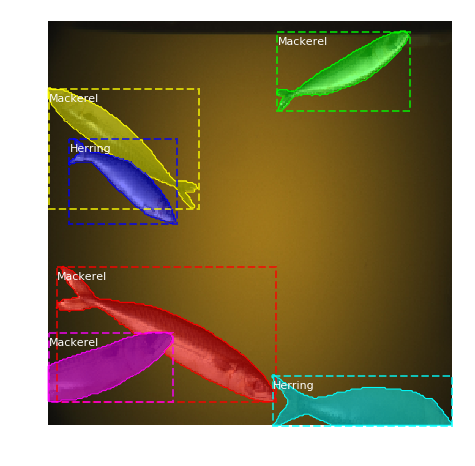

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


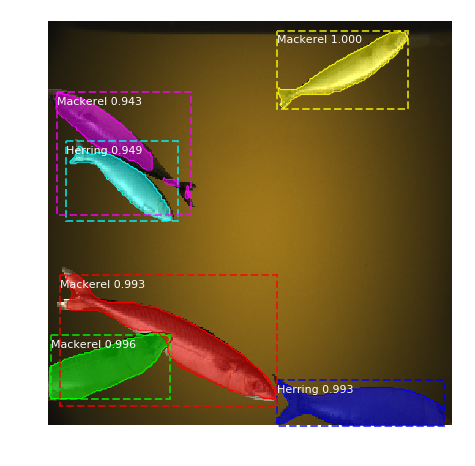

In [39]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Very minor modification by me.

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


class_names = ["bg", "mackerel","herring"]
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

Pretty good. It appears that the training data is correctly recognized.

Now... How about the validation and testing data. These datasets are generated by compositing the fish cutouts given in the problem assignment meaning that the data is derived from a different population than that used to train the model (blender generated images). Lets see the performance:

original_image           shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (4, 4)                min:   12.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 4)         min:    0.00000  max:    1.00000  bool


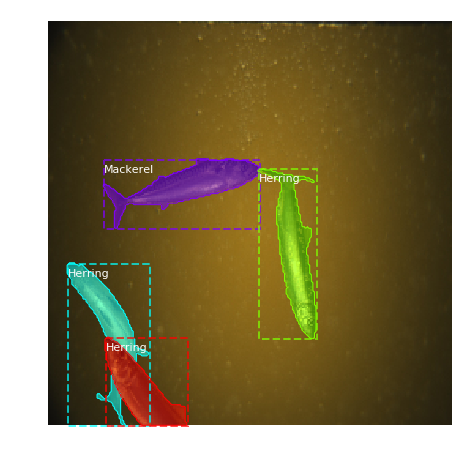

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -110.70000  max:  138.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


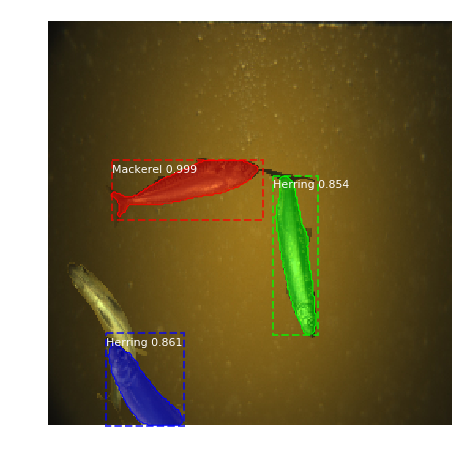

In [41]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Very minor modification by me.

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


class_names = ["bg", "mackerel","herring"]
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

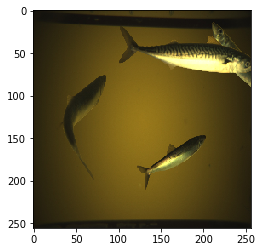

original_image           shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (4, 4)                min:   14.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 4)         min:    0.00000  max:    1.00000  bool


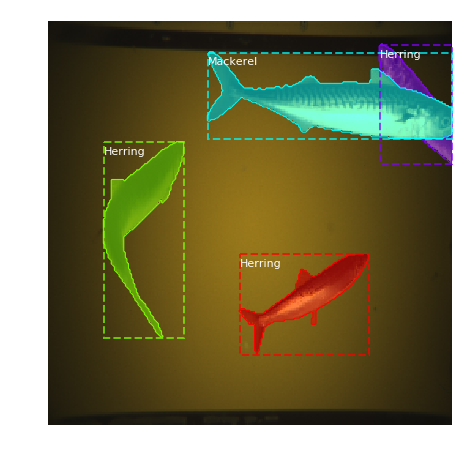

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -107.70000  max:  138.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


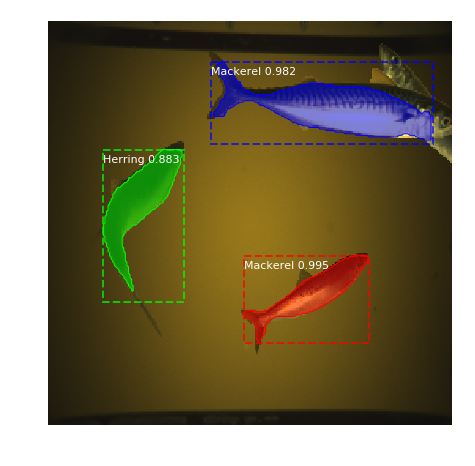

In [45]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Very minor modification by me.

# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)
plt.imshow(original_image)
plt.show()
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

Hmm.... Well.. The fishes are recognized, but it appears it has problem with overlapping fish and edge cases..

## Model evaluation
To evaluate my model I use the code from cell 14 in https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb.

First I see how it performes on the validation data. This data has not been used in training the data, but the composite images were generated from the rendered images generated in blender, that is, the fishes in the images are from the same "general" population as those in the training data.

In [47]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Very minor modification by me.

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_train.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9666666626930237


It performs really well on the training data.

Lets consider the validation and the testing datasets:

In [48]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Very minor modification by me.

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4175000040233135


In [49]:
# Code from: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# Very minor modification by me.

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.40055555875102683


This result is not very impressive, and is what is expected from a picking the instance class at random. I would have liked to see the performance if we generated the training data using more than one 3d model, maybe that would have made a model that generalized better to this real life data.